# 3 CLIP

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import clip
import numpy as np
import torchvision
import torch
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

## 3.1 Tasks

## 1. Inference using CLIP

In [4]:
imagenet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
imagenet_model = imagenet_model.to(device)
imagenet_model.eval()


clip_model, clip_preprocess = clip.load("RN50", device=device)
clip_model.eval()

clip_visual_encoder = clip_model.visual

print("Model comparison:")
print(f"ImageNet ResNet-50 architecture: {type(imagenet_model)}")
print(f"CLIP visual encoder architecture: {type(clip_visual_encoder)}")


print("\nArchitecture Comparison:")
print("ImageNet ResNet-50 layers:")
for name, module in imagenet_model.named_children():
    print(f"  {name}: {type(module)}")

print("\nCLIP visual encoder layers:")
for name, module in clip_visual_encoder.named_children():
    print(f"  {name}: {type(module)}")



Model comparison:
ImageNet ResNet-50 architecture: <class 'torchvision.models.resnet.ResNet'>
CLIP visual encoder architecture: <class 'clip.model.ModifiedResNet'>

Architecture Comparison:
ImageNet ResNet-50 layers:
  conv1: <class 'torch.nn.modules.conv.Conv2d'>
  bn1: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
  relu: <class 'torch.nn.modules.activation.ReLU'>
  maxpool: <class 'torch.nn.modules.pooling.MaxPool2d'>
  layer1: <class 'torch.nn.modules.container.Sequential'>
  layer2: <class 'torch.nn.modules.container.Sequential'>
  layer3: <class 'torch.nn.modules.container.Sequential'>
  layer4: <class 'torch.nn.modules.container.Sequential'>
  avgpool: <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>
  fc: <class 'torch.nn.modules.linear.Linear'>

CLIP visual encoder layers:
  conv1: <class 'torch.nn.modules.conv.Conv2d'>
  bn1: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
  relu1: <class 'torch.nn.modules.activation.ReLU'>
  conv2: <class 'torch.nn.modules.conv.Conv2

- Difference between ImageNet Pretrained RN50 and CLIP ResNet-50 (OpenAI)

### Projection Layer
CLIP's visual encoder adds a projection layer at the end that maps visual features to a multimodal embedding space that aligns with text features.


### Normalization
CLIP uses layer normalization in certain places where the standard ResNet uses batch normalization.


### Pooling
CLIP uses attention pooling instead of standard average pooling.

### Output Dimensionality
Standard ResNet-50 outputs logits for 1000 ImageNet classes directly, while CLIP's visual encoder outputs embeddings in a multimodal space.


### Preprocessing
CLIP typically uses a different input size and preprocessing pipeline compared to standard ImageNet models.



| Component               | ImageNet Pretrained RN50                          | CLIP ResNet-50 (OpenAI)                                |
|------------------------|---------------------------------------------------|--------------------------------------------------------|
| **Input Layer**       | 1 conv layer: 7×7 kernel + stride 2 + max pooling | 3 conv layers with smaller 3×3 kernels (no maxpool)    |
| **Pooling**            | Global average pooling                            | Attention pooling over spatial features                |
| **Final Layer**        | Fully connected (FC) layer → 1000 class logits    | Linear projection to a shared embedding space          |
| **Training Objective** | Cross-entropy (supervised classification)         | Contrastive loss (image-text alignment)                |




## 2. Setup data : Understanding ImageNet

1. What label hierarchy is used in ImageNet?

    ImageNet follows the WordNet hierarchy, which is a lexical database that groups English words into sets of synonyms called synsets. The hierarchy is organized as a tree, with more general concepts at the top and more specific ones at lower levels.
    - ImageNet uses a label hierarchy based on the WordNet lexical database. WordNet organizes English nouns into a hierarchical semantic tree of synsets (sets of synonymous terms), where:
        - Each node represents a concept.
        - Parent-child relationships represent “is-a” relationships (e.g., a “golden retriever” is-a “dog”).
        - For ImageNet, each image is associated with one synset (class) from a curated subset of WordNet called ILSVRC (ImageNet Large Scale Visual Recognition Challenge), comprising 1000 object categories.

2. What does a synset mean?
    - A synset (short for synonym set) in WordNet is a group of one or more synonymous words or phrases that represent a single concept (semantically equivalent).

    - In ImageNet:

        - Each class corresponds to a WordNet synset ID (e.g., n02119789 for “kit fox”).

        - Synsets provide semantic grounding for labels, helping align image annotations with natural language.

    For example, the synset for "dog" includes terms like "domestic dog", "Canis familiaris", etc. In ImageNet, each class corresponds to a WordNet synset.

3. Could grouping objects based on synsets lead to problems for visual recognition?
    - Yes — relying solely on synsets for grouping can introduce challenges:

        - a. Visual Inconsistency : Some synsets group visually diverse objects because they are semantically similar. For instance, “armchair” and “rocking chair” might share a synset, yet look very different.

        - b. Ambiguity in Object Boundaries : Objects belonging to closely related synsets (e.g., different dog breeds) can be visually similar, making fine-grained recognition difficult.

        - c. Language Bias vs. Visual Grounding : WordNet is linguistically grounded, not visually grounded. Some groupings might make sense in language but not visually (e.g., “zebra” and “okapi” are semantically close but look quite different).

4. Three types of visual differences in images of the same synset
    - Even within the same synset, there can be significant intra-class variation:

        - a. Pose and Orientation : An object may appear in different poses or orientations (e.g., a cat sitting vs. lying down).

        - b. Background and Context : Images may have cluttered or varying backgrounds, occlusions, or lighting changes that affect object visibility.

        - c. Appearance Variability : There may be differences in color, texture, or scale — for example, different breeds of dogs within the same synset, or different styles of the same object (e.g., modern vs. traditional chair).



## 3. Setup zero-shot CLIP


Testing models on sample image:
Image: sample_images/3_hen.jpeg


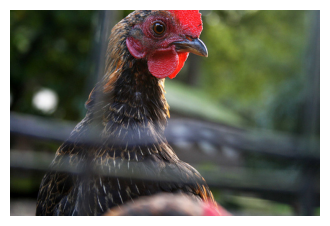

CLIP Prediction  CLIP Score RN50 Prediction  RN50 Score
0                hen    0.558105             hen    0.804588
1               cock    0.395752            cock    0.179813
2  Brabancon griffon    0.005733         vulture    0.014890
3           hornbill    0.003761   ruffed grouse    0.000198
4         rotisserie    0.002838        hornbill    0.000137

__________________________________________________



Image: sample_images/2_bee_eater.Jpeg


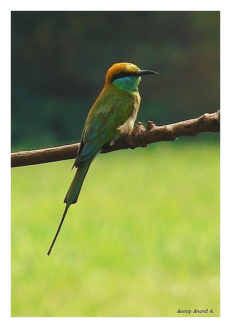

CLIP Prediction  CLIP Score RN50 Prediction  RN50 Score
0       bee eater    0.891602       bee eater    0.998648
1         jacamar    0.104858         jacamar    0.001262
2         upright    0.000801     hummingbird    0.000036
3          bulbul    0.000463  indigo bunting    0.000020
4            titi    0.000384           macaw    0.000009

__________________________________________________



Image: sample_images/1_tiger_shark.jpeg


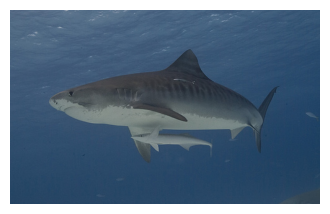

CLIP Prediction  CLIP Score    RN50 Prediction    RN50 Score
0        tiger shark    0.918457        tiger shark  9.992273e-01
1  great white shark    0.039093  great white shark  6.875960e-04
2         hammerhead    0.032410         hammerhead  8.194538e-05
3           sturgeon    0.006092           sturgeon  7.535673e-07
4               coho    0.000441                gar  6.725373e-07

__________________________________________________



Image: sample_images/4_black_swan.Jpeg


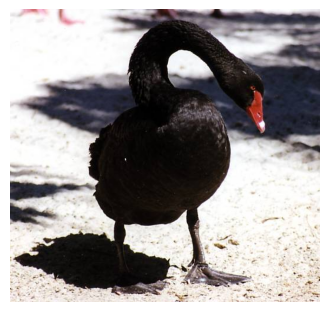

CLIP Prediction  CLIP Score RN50 Prediction  RN50 Score
0      black swan    0.599121      black swan    0.996910
1   American coot    0.301270           goose    0.002514
2           goose    0.047668   American coot    0.000302
3            cock    0.011322             hen    0.000209
4     black stork    0.006252           drake    0.000036

__________________________________________________





In [23]:

imagenet_classes = torchvision.models.ResNet50_Weights.IMAGENET1K_V1.meta["categories"]
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in imagenet_classes]).to(device)

def predict_with_clip(image_path):
    image = clip_preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(5)

    return [(imagenet_classes[idx], values[i].item()) for i, idx in enumerate(indices)]


imagenet_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_with_imagenet(image_path):
    image = imagenet_preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    with torch.no_grad():
        output = imagenet_model(image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        values, indices = probabilities.topk(5)

    return [(imagenet_classes[idx], values[i].item()) for i, idx in enumerate(indices)]



print("\nTesting models on sample image:")

for path in os.listdir('sample_images'):

    img_path = os.path.join('sample_images', path)
    print(f"Image: {img_path}")
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    clip_preds = predict_with_clip(img_path)    
    rn_preds = predict_with_imagenet(img_path)    
    
    df = pd.DataFrame({
        'CLIP Prediction': [cls for cls, _ in clip_preds],
        'CLIP Score': [score for _, score in clip_preds],
        'RN50 Prediction': [cls for cls, _ in rn_preds],
        'RN50 Score': [score for _, score in rn_preds],
    })

    display(df)
    print("_" * 50)
    print("\n\n")

## 4. CLIP vs ImageNet pretraining


Predictions for: bulbul


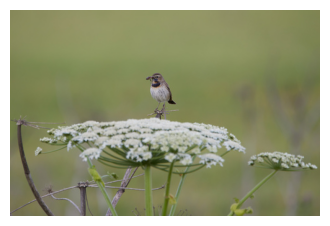

CLIP Prediction CLIP Score    RN50 Prediction RN50 Score
0      6, stingray     0.3850       16, bulbul ✅     0.6044
1        13, junco     0.1103          13, junco     0.0996
2       9, ostrich     0.0914    12, house_finch     0.0850
3          7, cock     0.0572          15, robin     0.0370
4  12, house_finch     0.0453  82, ruffed_grouse     0.0298


Predictions for: flamingo


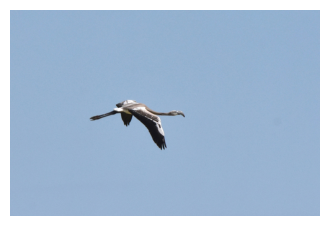

CLIP Prediction CLIP Score     RN50 Prediction RN50 Score
0  140, red-backed_sandpiper     0.3872     130, flamingo ✅     0.3895
1             142, dowitcher     0.2137  123, spiny_lobster     0.1388
2       139, ruddy_turnstone     0.1493      142, dowitcher     0.1257
3         123, spiny_lobster     0.0948       124, crayfish     0.0994
4              124, crayfish     0.0371             17, jay     0.0747


Predictions for: hognose_snake


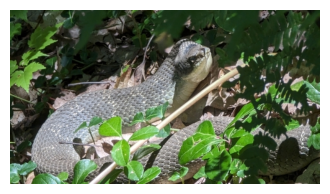

CLIP Prediction CLIP Score         RN50 Prediction RN50 Score
0    44, alligator_lizard     0.4172          59, vine_snake     0.4233
1          35, mud_turtle     0.2415  50, american_alligator     0.3818
2  40, american_chameleon     0.0433     54, hognose_snake ✅     0.1344
3        63, indian_cobra     0.0376          56, king_snake     0.0156
4       48, komodo_dragon     0.0259         64, green_mamba     0.0135


Predictions for: ptarmigan


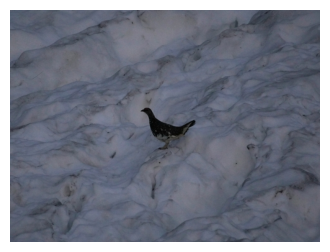

CLIP Prediction CLIP Score    RN50 Prediction RN50 Score
0       77, wolf_spider     0.7563    81, ptarmigan ✅     0.3021
1         76, tarantula     0.1107           78, tick     0.2377
2            16, bulbul     0.0682  82, ruffed_grouse     0.1236
3              78, tick     0.0152    77, wolf_spider     0.1114
4  139, ruddy_turnstone     0.0111         16, bulbul     0.0852


Predictions for: water_snake


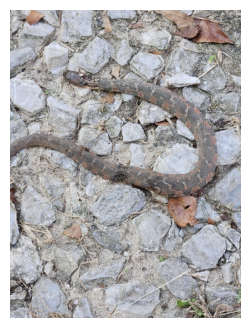

CLIP Prediction CLIP Score         RN50 Prediction RN50 Score
0                309, bee     0.1255       54, hognose_snake     0.6637
1  40, american_chameleon     0.1160       58, water_snake ✅     0.1241
2          22, bald_eagle     0.0726          56, king_snake     0.1220
3            596, hatchet     0.0548     61, boa_constrictor     0.0457
4          484, catamaran     0.0499  50, american_alligator     0.0126


Predictions for: agama


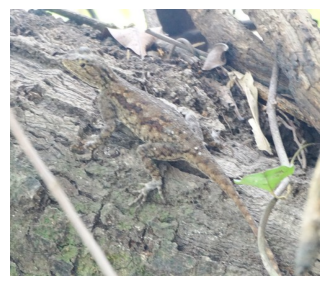

CLIP Prediction CLIP Score   RN50 Prediction RN50 Score
0        35, mud_turtle     0.2312    37, box_turtle     0.3051
1      63, indian_cobra     0.1296      36, terrapin     0.1602
2      38, banded_gecko     0.1180  38, banded_gecko     0.1538
3              78, tick     0.0516       42, agama ✅     0.0805
4  44, alligator_lizard     0.0434    35, mud_turtle     0.0472


Predictions for: beaver


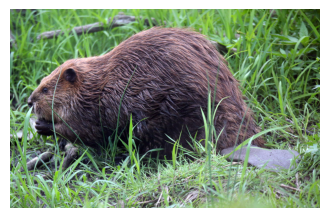

CLIP Prediction CLIP Score  RN50 Prediction RN50 Score
0    333, hamster     0.7861     333, hamster     0.8253
1    353, gazelle     0.0803  338, guinea_pig     0.0595
2     290, jaguar     0.0606      356, weasel     0.0388
3     356, weasel     0.0109      290, jaguar     0.0196
4     332, angora     0.0099    337, beaver ✅     0.0194


Predictions for: bighorn


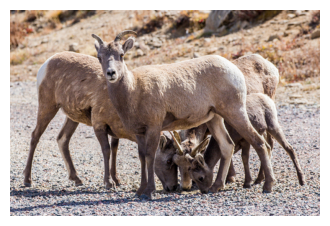

CLIP Prediction CLIP Score     RN50 Prediction RN50 Score
0             345, ox     0.9072             345, ox     0.8666
1  346, water_buffalo     0.0488   344, hippopotamus     0.1264
2   344, hippopotamus     0.0156  346, water_buffalo     0.0068
3         339, sorrel     0.0116          347, bison     0.0002
4     367, chimpanzee     0.0050      349, bighorn ✅     0.0000


Predictions for: brambling


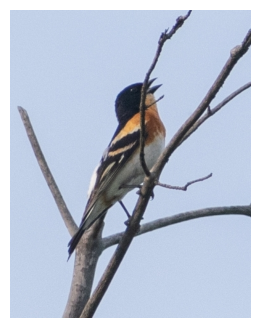

CLIP Prediction CLIP Score  RN50 Prediction RN50 Score
0                 6, stingray     0.8179      6, stingray     0.9634
1               11, goldfinch     0.0583        88, macaw     0.0155
2              877, turnstile     0.0338          7, cock     0.0080
3                  91, coucal     0.0251           8, hen     0.0052
4  986, yellow_lady's_slipper     0.0243  10, brambling ✅     0.0020


Predictions for: loggerhead


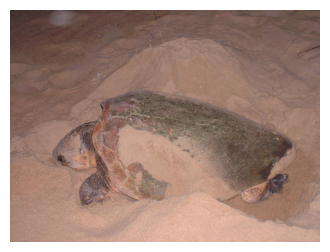

CLIP Prediction CLIP Score   RN50 Prediction RN50 Score
0      29, axolotl     0.5566       29, axolotl     0.7298
1    31, tree_frog     0.1836      30, bullfrog     0.2608
2  32, tailed_frog     0.0634     31, tree_frog     0.0058
3     30, bullfrog     0.0350   32, tailed_frog     0.0015
4    115, sea_slug     0.0248  33, loggerhead ✅     0.0006

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# List of images and true labels
imagenet_rn50_better = [
    ("imagenet_rn50_better/bulbul.jpg", "bulbul"),
    ("imagenet_rn50_better/flamingo.jpg", "flamingo"),
    ("imagenet_rn50_better/hognose_snake.jpeg", "hognose_snake"),
    ("imagenet_rn50_better/ptarmigan.jpeg", "ptarmigan"),
    ("imagenet_rn50_better/water_snake.jpeg", "water_snake"),
    ("imagenet_rn50_better/agama.jpeg", "agama"),
    ("imagenet_rn50_better/beaver.jpeg", "beaver"),
    ("imagenet_rn50_better/bighorn.jpg", "bighorn"),
    ("imagenet_rn50_better/brambling.jpeg", "brambling"),
    ("imagenet_rn50_better/loggerhead.jpeg", "loggerhead"),
]

for img_path, true_label in imagenet_rn50_better:
    print(f"\nPredictions for: {true_label}")
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    clip_preds = predict_with_clip(img_path)    
    rn_preds = predict_with_imagenet(img_path)    
    
    def annotate_preds(preds):
        annotated_labels = []
        scores = []
        for cls_str, score in preds:
            label_name = cls_str.split(", ", 1)[1] if ", " in cls_str else cls_str
            tick = " ✅" if label_name == true_label else ""
            annotated_labels.append(f"{cls_str}{tick}")
            scores.append(score)
        return annotated_labels, scores
    
    clip_labels, clip_scores = annotate_preds(clip_preds)
    rn_labels, rn_scores = annotate_preds(rn_preds)
    
    df = pd.DataFrame({
        'CLIP Prediction': clip_labels,
        'CLIP Score': [f"{s:.4f}" for s in clip_scores],
        'RN50 Prediction': rn_labels,
        'RN50 Score': [f"{s:.4f}" for s in rn_scores],
    })
    
    display(df)
#? Prompt: Add tick marks if the prediction is correct, split label name
#? after the comma and space for correct label name and compare with GT



Predictions for: agama


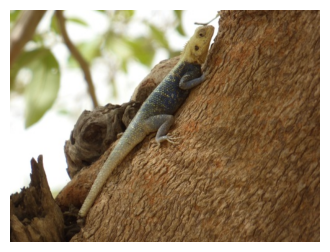

CLIP Prediction CLIP Score         RN50 Prediction RN50 Score
0    38, banded_gecko     0.6079        38, banded_gecko     0.8325
1      35, mud_turtle     0.1490  34, leatherback_turtle     0.0220
2  43, frilled_lizard     0.0811       39, common_iguana     0.0177
3         42, agama ✅     0.0427          22, bald_eagle     0.0138
4        36, terrapin     0.0229          35, mud_turtle     0.0114


Predictions for: agama


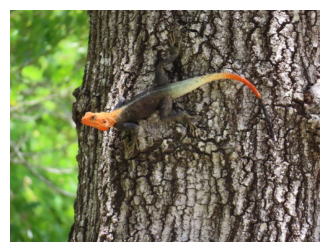

CLIP Prediction CLIP Score         RN50 Prediction RN50 Score
0          22, bald_eagle     0.4106             23, vulture     0.5526
1             23, vulture     0.1158        38, banded_gecko     0.3542
2               331, hare     0.1022          22, bald_eagle     0.0554
3             42, agama ✅     0.0413            36, terrapin     0.0257
4  40, american_chameleon     0.0376  34, leatherback_turtle     0.0045


Predictions for: beaver


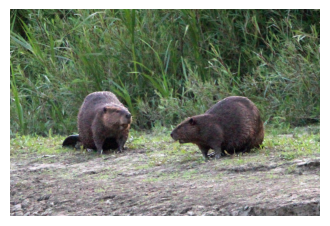

CLIP Prediction CLIP Score  RN50 Prediction RN50 Score
0   294, brown_bear     0.5298     102, echidna     0.8730
1      333, hamster     0.0920     333, hamster     0.0698
2      353, gazelle     0.0643  294, brown_bear     0.0336
3     337, beaver ✅     0.0567      332, angora     0.0084
4  330, wood_rabbit     0.0409  338, guinea_pig     0.0067


Predictions for: beaver


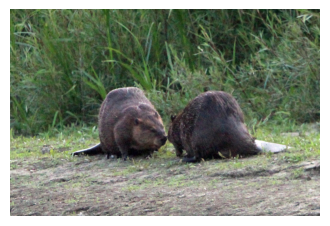

CLIP Prediction CLIP Score  RN50 Prediction RN50 Score
0      333, hamster     0.2632     333, hamster     0.7462
1   294, brown_bear     0.1986     102, echidna     0.2488
2      102, echidna     0.1030      332, angora     0.0028
3     337, beaver ✅     0.0909      356, weasel     0.0008
4  330, wood_rabbit     0.0569  338, guinea_pig     0.0004


Predictions for: bighorn


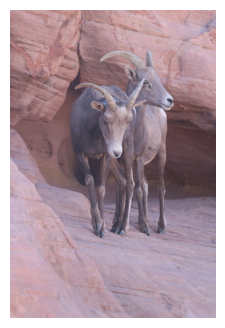

CLIP Prediction CLIP Score     RN50 Prediction RN50 Score
0             345, ox     0.8452             345, ox     0.9820
1  346, water_buffalo     0.1144   344, hippopotamus     0.0162
2   344, hippopotamus     0.0105  346, water_buffalo     0.0016
3         339, sorrel     0.0073           350, ibex     0.0001
4      349, bighorn ✅     0.0030      342, wild_boar     0.0000


Predictions for: bighorn


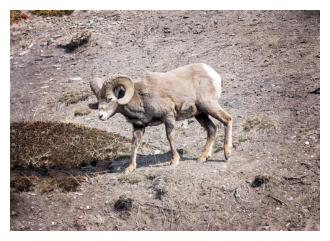

CLIP Prediction CLIP Score     RN50 Prediction RN50 Score
0             345, ox     0.9497             345, ox     0.7488
1  346, water_buffalo     0.0301   344, hippopotamus     0.2512
2   344, hippopotamus     0.0104  346, water_buffalo     0.0000
3      349, bighorn ✅     0.0025          347, bison     0.0000
4         339, sorrel     0.0021      342, wild_boar     0.0000


Predictions for: brambling


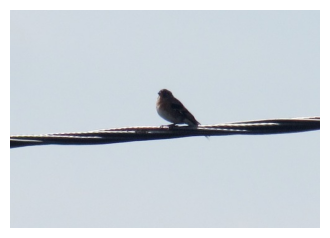

CLIP Prediction CLIP Score          RN50 Prediction RN50 Score
0      877, turnstile     0.1578                   8, hen     0.7617
1  904, window_screen     0.1248               9, ostrich     0.1093
2              8, hen     0.1229              6, stingray     0.0876
3          9, ostrich     0.0679  136, european_gallinule     0.0110
4     10, brambling ✅     0.0459          12, house_finch     0.0084


Predictions for: brambling


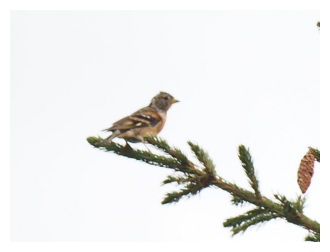

CLIP Prediction CLIP Score    RN50 Prediction RN50 Score
0                 6, stingray     0.7148        6, stingray     0.9960
1  986, yellow_lady's_slipper     0.1522       135, limpkin     0.0010
2              877, turnstile     0.0373           78, tick     0.0007
3                  9, ostrich     0.0160      11, goldfinch     0.0006
4             10, brambling ✅     0.0135  82, ruffed_grouse     0.0004


Predictions for: bulbul


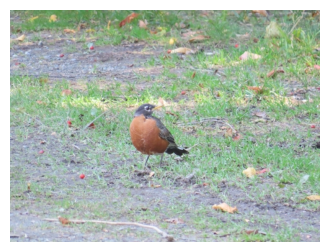

CLIP Prediction CLIP Score    RN50 Prediction RN50 Score
0       6, stingray     0.5698      11, goldfinch     0.9997
1     11, goldfinch     0.2412        6, stingray     0.0001
2  87, african_grey     0.0834          908, wing     0.0000
3     81, ptarmigan     0.0332   87, african_grey     0.0000
4      16, bulbul ✅     0.0192  82, ruffed_grouse     0.0000


Predictions for: bulbul


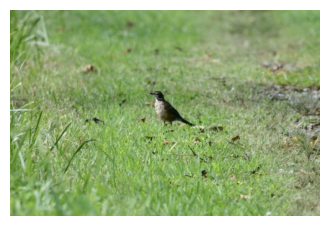

CLIP Prediction CLIP Score    RN50 Prediction RN50 Score
0     16, bulbul ✅     0.6650   87, african_grey     0.4300
1  12, house_finch     0.1531      11, goldfinch     0.1014
2      6, stingray     0.0563  82, ruffed_grouse     0.0859
3    11, goldfinch     0.0316           78, tick     0.0692
4    81, ptarmigan     0.0242      81, ptarmigan     0.0687


Predictions for: flamingo


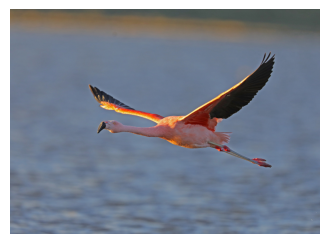

CLIP Prediction CLIP Score            RN50 Prediction RN50 Score
0           126, isopod     0.2852           125, hermit_crab     0.5288
1  139, ruddy_turnstone     0.1841                126, isopod     0.2289
2      125, hermit_crab     0.1389             689, overskirt     0.0586
3    123, spiny_lobster     0.1099  140, red-backed_sandpiper     0.0411
4       130, flamingo ✅     0.0656           128, black_stork     0.0210


Predictions for: flamingo


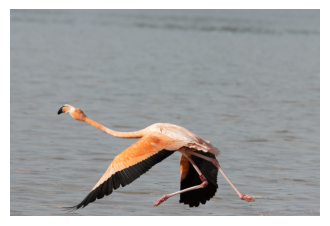

CLIP Prediction CLIP Score            RN50 Prediction RN50 Score
0                126, isopod     0.2666                126, isopod     0.9868
1              124, crayfish     0.1891           125, hermit_crab     0.0111
2           125, hermit_crab     0.1749                 96, toucan     0.0006
3  140, red-backed_sandpiper     0.1472    117, chambered_nautilus     0.0003
4            130, flamingo ✅     0.0685  140, red-backed_sandpiper     0.0002


Predictions for: hognose_snake


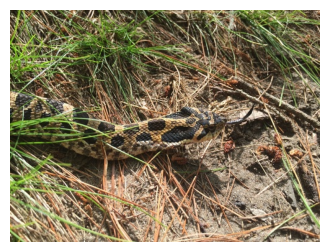

CLIP Prediction CLIP Score         RN50 Prediction RN50 Score
0       48, komodo_dragon     0.2224  50, american_alligator     0.8884
1      53, ringneck_snake     0.1705         58, water_snake     0.0401
2     54, hognose_snake ✅     0.0781          56, king_snake     0.0211
3         64, green_mamba     0.0768         64, green_mamba     0.0180
4  50, american_alligator     0.0768        63, indian_cobra     0.0116


Predictions for: hognose_snake


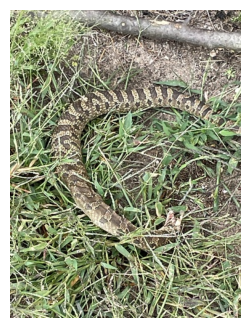

CLIP Prediction CLIP Score         RN50 Prediction RN50 Score
0      53, ringneck_snake     0.3215  50, american_alligator     0.8399
1  50, american_alligator     0.1891         64, green_mamba     0.0718
2        63, indian_cobra     0.1260        63, indian_cobra     0.0334
3       48, komodo_dragon     0.1129          56, king_snake     0.0306
4     54, hognose_snake ✅     0.1094         58, water_snake     0.0136


Predictions for: loggerhead


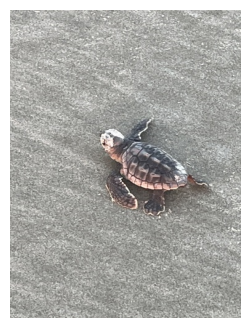

CLIP Prediction CLIP Score        RN50 Prediction RN50 Score
0      31, tree_frog     0.5337            29, axolotl     0.4500
1   33, loggerhead ✅     0.1995  122, american_lobster     0.1482
2    32, tailed_frog     0.1459           30, bullfrog     0.1167
3        29, axolotl     0.0224         121, king_crab     0.0701
4  747, punching_bag     0.0107               310, ant     0.0678


Predictions for: loggerhead


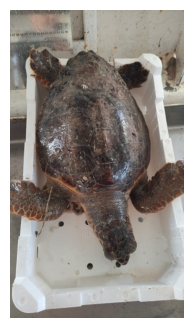

CLIP Prediction CLIP Score        RN50 Prediction RN50 Score
0       29, axolotl     0.4639            29, axolotl     0.8351
1     31, tree_frog     0.1229           30, bullfrog     0.1265
2  33, loggerhead ✅     0.0957        32, tailed_frog     0.0283
3      30, bullfrog     0.0781          31, tree_frog     0.0054
4   32, tailed_frog     0.0497  122, american_lobster     0.0030


Predictions for: ptarmigan


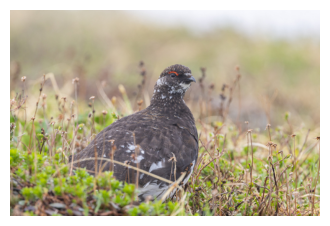

CLIP Prediction CLIP Score    RN50 Prediction RN50 Score
0    76, tarantula     0.7466    77, wolf_spider     0.4698
1  77, wolf_spider     0.1859      76, tarantula     0.3449
2  81, ptarmigan ✅     0.0205      79, centipede     0.0889
3       16, bulbul     0.0178  82, ruffed_grouse     0.0488
4         78, tick     0.0157           78, tick     0.0359


Predictions for: ptarmigan


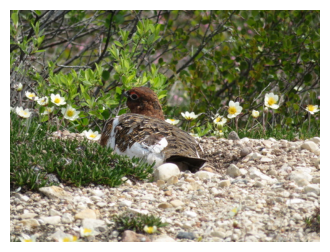

CLIP Prediction CLIP Score    RN50 Prediction RN50 Score
0    77, wolf_spider     0.6602    77, wolf_spider     0.9936
1           78, tick     0.1383           78, tick     0.0038
2    81, ptarmigan ✅     0.1012       135, limpkin     0.0011
3  82, ruffed_grouse     0.0486  82, ruffed_grouse     0.0004
4      76, tarantula     0.0123      76, tarantula     0.0003


Predictions for: water_snake


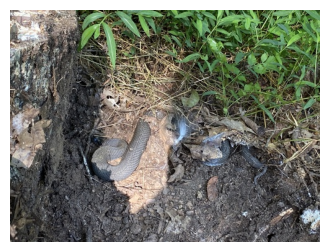

CLIP Prediction CLIP Score         RN50 Prediction RN50 Score
0         58, water_snake ✅     0.1744   49, african_crocodile     0.5558
1          57, garter_snake     0.1010          59, vine_snake     0.3248
2  359, black-footed_ferret     0.0786  50, american_alligator     0.0625
3         48, komodo_dragon     0.0469       54, hognose_snake     0.0251
4            35, mud_turtle     0.0421       48, komodo_dragon     0.0194


Predictions for: water_snake


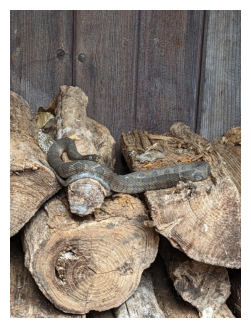

CLIP Prediction CLIP Score          RN50 Prediction RN50 Score
0         57, garter_snake     0.1326              630, loafer     0.1968
1        58, water_snake ✅     0.0411        39, common_iguana     0.1563
2              849, teapot     0.0386           35, mud_turtle     0.1383
3         38, banded_gecko     0.0374  487, cellular_telephone     0.0679
4  487, cellular_telephone     0.0335           592, hard_disc     0.0669

In [35]:
clip_better = [
    ("clip_better/agama_1.jpeg", "agama"),
    ("clip_better/agama_2.jpeg", "agama"),
    ("clip_better/beaver_1.jpg", "beaver"),
    ("clip_better/beaver_2.jpg", "beaver"),
    ("clip_better/bighorn_1.jpg", "bighorn"),
    ("clip_better/bighorn_2.jpg", "bighorn"),
    ("clip_better/brambling_1.jpeg", "brambling"),
    ("clip_better/brambling_2.jpeg", "brambling"),
    ("clip_better/bulbul_1.jpeg", "bulbul"),
    ("clip_better/bulbul_2.jpg", "bulbul"),
    ("clip_better/flamingo_1.jpg", "flamingo"),
    ("clip_better/flamingo_2.jpg", "flamingo"),
    ("clip_better/hognose_snake_1.jpg", "hognose_snake"),
    ("clip_better/hognose_snake_2.jpg", "hognose_snake"),
    ("clip_better/loggerhead_1.jpg", "loggerhead"),
    ("clip_better/loggerhead_2.jpeg", "loggerhead"),
    ("clip_better/ptarmigan_1.jpg", "ptarmigan"),
    ("clip_better/ptarmigan_2.jpg", "ptarmigan"),
    ("clip_better/water_snake_1.jpg", "water_snake"),
    ("clip_better/water_snake_2.jpeg", "water_snake")
]

for img_path, true_label in clip_better:
    print(f"\nPredictions for: {true_label}")
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    clip_preds = predict_with_clip(img_path)    
    rn_preds = predict_with_imagenet(img_path)    
    
    def annotate_preds(preds):
        annotated_labels = []
        scores = []
        for cls_str, score in preds:
            label_name = cls_str.split(", ", 1)[1] if ", " in cls_str else cls_str
            tick = " ✅" if label_name == true_label else ""
            annotated_labels.append(f"{cls_str}{tick}")
            scores.append(score)
        return annotated_labels, scores
    
    clip_labels, clip_scores = annotate_preds(clip_preds)
    rn_labels, rn_scores = annotate_preds(rn_preds)
    
    df = pd.DataFrame({
        'CLIP Prediction': clip_labels,
        'CLIP Score': [f"{s:.4f}" for s in clip_scores],
        'RN50 Prediction': rn_labels,
        'RN50 Score': [f"{s:.4f}" for s in rn_scores],
    })
    
    display(df)

## 5. FP16 v/s FP32

In [1]:
def load_clip_fp32():
    clip_model, _ = clip.load("RN50", device=device)
    return clip_model.visual.float()

def load_clip_fp16():
    clip_model, _ = clip.load("RN50", device=device)
    return clip_model.visual.half()


#### Inference time Comparison b/w F32 and F16

In [9]:

image_paths = [
    'sample_images/banana.jpeg',
    'sample_images/goldfish.jpeg',
    'sample_images/hen.jpeg',
    'sample_images/ladybug.jpeg',
    'sample_images/macaw.jpeg',
    'sample_images/peacock.jpeg',
    'sample_images/pineapple.jpeg',
    'sample_images/ski.jpeg',
]

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")

print(f"PyTorch Version: {torch.__version__}")

sample_image = clip_preprocess(Image.open(image_paths[0])).unsqueeze(0).to(device)
sample_image = sample_image.repeat(64, 1, 1, 1)

clip_visual_fp32 = load_clip_fp32()
clip_visual_fp16 = load_clip_fp16()

print("Model-F32 dtype:", next(clip_visual_fp32.parameters()).dtype) 
print("Model-F16 dtype:", next(clip_visual_fp16.parameters()).dtype)


print("\nTiming tests:")
# Measure inference time for FP32 and FP16 models using cuda events
def measure_time(model, input_tensor, dtype, iterations=100):
    times = []
    for _ in range(iterations):
        if torch.cuda.is_available():
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)

            torch.cuda.synchronize()
            start_event.record()
            
            with torch.autocast(device_type='cuda', dtype=dtype):
                with torch.no_grad():
                    _ = model(input_tensor)
                
            end_event.record()
            torch.cuda.synchronize()
            
            times.append(start_event.elapsed_time(end_event) / 1000)
    
    return np.mean(times), np.std(times)

fp32_mean, fp32_std = measure_time(
    clip_visual_fp32, 
    sample_image.to(torch.float32),
    torch.float32
)

fp16_mean, fp16_std = measure_time(
    clip_visual_fp16,
    sample_image.to(torch.float16),
    torch.float16
)

print(f"FP32 inference time: {fp32_mean:.6f} ± {fp32_std:.6f} seconds")
print(f"FP16 inference time: {fp16_mean:.6f} ± {fp16_std:.6f} seconds")
print(f"Speed ratio (FP32/FP16): {fp32_mean/fp16_mean:.2f}x")

GPU: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Version: 12.4
PyTorch Version: 2.6.0+cu124
Model-F32 dtype: torch.float32
Model-F16 dtype: torch.float16

Timing tests:
FP32 inference time: 0.190929 ± 0.002220 seconds
FP16 inference time: 0.099642 ± 0.000212 seconds
Speed ratio (FP32/FP16): 1.92x


#### Output Comparision b/w F16 and F32 Outputs

In [10]:
for img_path in image_paths:
    with torch.no_grad():
        img = clip_preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        fp32_output = clip_visual_fp32(img.to(torch.float32))
        fp16_output = clip_visual_fp16(img.to(torch.float16))
        
        fp16_as_fp32 = fp16_output.to(torch.float32)
        
        abs_diff = torch.abs(fp32_output - fp16_as_fp32)
        rel_diff = abs_diff / (torch.abs(fp32_output) + 1e-8)
        print(f"For Image - {img_path}")
        print(f"Mean absolute difference: {abs_diff.mean().item():.8f}")
        print(f"Mean relative difference: {rel_diff.mean().item():.8f}")
        print(f"Are there significant differences? {'Yes' if abs_diff.max().item() > 0.01 else 'No'}")
        print("")

For Image - sample_images/banana.jpeg
Mean absolute difference: 0.00021238
Mean relative difference: 0.02498327
Are there significant differences? No

For Image - sample_images/goldfish.jpeg
Mean absolute difference: 0.00027813
Mean relative difference: 0.02662759
Are there significant differences? No

For Image - sample_images/hen.jpeg
Mean absolute difference: 0.00019488
Mean relative difference: 0.02577461
Are there significant differences? No

For Image - sample_images/ladybug.jpeg
Mean absolute difference: 0.00028162
Mean relative difference: 0.03575969
Are there significant differences? No

For Image - sample_images/macaw.jpeg
Mean absolute difference: 0.00018306
Mean relative difference: 0.02474652
Are there significant differences? No

For Image - sample_images/peacock.jpeg
Mean absolute difference: 0.00024210
Mean relative difference: 0.04263122
Are there significant differences? No

For Image - sample_images/pineapple.jpeg
Mean absolute difference: 0.00023288
Mean relative di

#### Memory Usage Comparison

In [14]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

sample_image = clip_preprocess(Image.open(image_paths[0])).unsqueeze(0).to(device)
sample_image = sample_image.repeat(64, 1, 1, 1)

clip_visual_fp32 = load_clip_fp32()

with torch.autocast(device_type='cuda', dtype=torch.float32):
    with torch.no_grad():
        _ = clip_visual_fp32(sample_image.to(torch.float32))
fp32_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)

del clip_visual_fp32

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

clip_visual_fp16 = load_clip_fp16()

with torch.autocast(device_type='cuda', dtype=torch.float16):
    with torch.no_grad():
        _ = clip_visual_fp16(sample_image.to(torch.float16))
    fp16_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)

print(f"FP32 peak memory usage: {fp32_memory:.2f} MB")
print(f"FP16 peak memory usage: {fp16_memory:.2f} MB")
print(f"Memory change: {(fp16_memory/fp32_memory - 1) * 100:.2f}%")

FP32 peak memory usage: 1302.00 MB
FP16 peak memory usage: 829.09 MB
Memory change: -36.32%


In [13]:
sample_image = clip_preprocess(Image.open(image_paths[0])).unsqueeze(0).to(device)
sample_image = sample_image.repeat(64, 1, 1, 1)

clip_visual_fp32 = load_clip_fp32().to(device)
with profile(activities=[ProfilerActivity.CUDA], with_stack=True, profile_memory=True) as prof:
    with record_function("fp32_forward"):
        with torch.no_grad():
            _ = clip_visual_fp32(sample_image.to(torch.float32))

print("\nFP32 Profiling Summary:")
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

del clip_visual_fp32
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

clip_visual_fp16 = load_clip_fp16().to(device)
with profile(activities=[ProfilerActivity.CUDA], with_stack=True, profile_memory=True) as prof:
    with record_function("fp16_forward"):
        with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
            _ = clip_visual_fp16(sample_image.to(torch.float16))

print("\nFP16 Profiling Summary:")
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))



FP32 Profiling Summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               [memory]         0.00%       0.000us         0.00%       0.000us       0.000us       0.000us         0.00%       0.000us       0.000us           0 b           0 b  

[W421 23:11:03.676836456 collection.cpp:992] Warning: Failed to recover relationship between all profiler and kineto events: 316 vs. 0  reassociated. (function reassociate)



FP16 Profiling Summary:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel         1.29%       1.302ms         1.29%       1.302ms       3.794us       0.000us         0.00%       0.000us       0.000us           0 b           0 b           343  
void at::native::vectorized_elementwise_kernel<4, at...         0.00% 

[W421 23:11:04.246852204 collection.cpp:992] Warning: Failed to recover relationship between all profiler and kineto events: 540 vs. 0  reassociated. (function reassociate)


#### Analysis

- Lower Memory Usage with FP16: FP16 (16-bit) uses a little over half the memory compared to FP32 (32-bit), which allows more data or larger models to fit into GPU memory.

- Faster and More Efficient: FP16 runs faster because it uses special GPU hardware (Tensor Cores) optimized for lower precision, reducing the time and memory needed for each operation.

- Better for Larger Batches: Because it uses less memory, FP16 will allow us to run bigger batches or more parallel processes without running out of GPU memory.

 Referenced https://github.com/openai/CLIP